In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable

%matplotlib inline

In [2]:
# NOTE: all the code below were adapted from the trigiagonal_matrix_fun.ipnb notebook under the Codes section

In [11]:
def create_tri_mat(N):
    """
    Creates a vector of size N x 3 to store the tridiagonal matrix A

    The first column stores the sub-diagonal (-2 values from second element onwards)
    The second column stores the main diagonal (10 values along the entire column)
    The third column stores the super-diagonal (-4 values from the first element up till the second to last element)

    :param N:
    :return:
    """

    A_tri = np.zeros((N, 3))

    # sub-diagonal
    A_tri[1:N, 0] = -2 * np.ones((N - 1, ))

    # diagonal
    A_tri[0:N, 1] = 10 * np.ones((N, ))

    # super-diagonal
    A_tri[0:N - 1, 2] = -4 * np.ones((N - 1, ))

    # print(f"INSIDE A-tri: {A_tri}")

    return A_tri


In [4]:
def create_dense_mat(A_tri, N):
    """
    Creates a dense matrix using the tridiagonal format of A

    Fills in the dense format of A row by row, using the index i for the main diagonal (interval from [i - 1, i + 1])
    For the edge cases (i.e., first and last rows), we check if the column index j is within range (doesn't go out of
     bounds)

    :param A_tri:
    :param N:
    :return:
    """
    A_dense = np.zeros((N, N))

    # go over all rows
    for i in range(N):
        # only 3 non-zero entries in each row
        # this will go through entries (i,i-1), (i,i) and (i,i+1)
        for j in range(i - 1, i + 2):
            if 0 <= j <= N - 1:
                A_dense[i, j] = A_tri[i, j - i + 1]

    return A_dense


In [5]:
def tri_mat_vec(A_tri, x):
    """
    Takes in

    :param A_tri:
    :param x:
    :return:
    """

    N = len(x)
    y = np.zeros((N, ))

    # go over all rows
    for i in range(N):
        # this will go through entries (i,i-1), (i,i) and (i,i+1)
        for j in range(i - 1, i + 2):
            if 0 <= j <= N-1:
                y[i] += A_tri[i, j - i + 1] * x[j]

    return y


In [6]:
def back_sub_tri(A_tri, b, x, n):
    """
    The part of Gaussian Elimination that does the backward substitution (can be reused in both versions without row swapping and with partial pivoting)

    Note: need to pass n from the parent function (Gaussian Elimination that determines the size of A and b)

    :param A: square matrix of size n x n (already performed forward elimination where A is an upper triangular matrix)
    :param b: column vector of size n x 1
    :param x: solution vector x to Ax = b
    :param n: size n from A and b
    :return:
    """

    # need to find multiplier for last element (just the last element in the main diagonal -- middle element)
    x[n - 1] = b[n - 1] / A_tri[n - 1][1]

    for i in reversed(range(0, n - 1)):
        temp = b[i]

        # only need to subtract the right term (super-diagonal) only nonzero term -- only diagonal and super-diagonal
        # since the super-diagonal is shifted up by 1, use j - 1 or i
        j = i + 1
        temp = temp - (A_tri[i][2] * x[j])

        # update using the middle element (main diagonal) in the ith row
        x[i] = temp / A_tri[i][1]


In [7]:
def forward_elim_no_row_swap_tri(A_tri, b, n):
    """
    The part of Gaussian Elimination that does the forward elimination (only for version without row swapping)

    Note: need to pass n from the parent function (Gaussian Elimination that determines the size of A and b)

    :param A_tri: square matrix of size n x n
    :param b: column vector of size n x 1
    :param n: size n from A and b
    :return:
    """

    for k in range(n - 1):
        # only need to eliminate one row per step (the immediate row below the current row)
        i = k + 1

        # find multiplier to zero out A[i][k] in the ith row
        # so, divide the left element (sub-diagonal) by the middle element (middle diagonal)
        # remember that the sub-diagonal is shifted to the right (starts at the second element) -> k + 1 or i
        # print(f"left: {A_tri[0][i]}")
        # print(f"right: {A_tri[1][k]}")
        x_mult = A_tri[i][0] / A_tri[k][1]

        if DEBUG:
            print(f"x mult: {x_mult}")

        # typo in pseudocode, should be set to 0 instead of x_mult
        # set the left element (sub-diagonal) to 0
        A_tri[i][0] = 0

        # update ith row of A
        # 1 - need to update the middle element (main diagonal) in the immediate row below (the left element is zeroed
        # out above and the right element has a 0 right above it, so no update is needed)
        # 2 - also need to update the left element (sub-diagonal) two rows below (again, there are zeros above the
        # middle and right elements on the original row)

        # subtract the middle element (main diagonal) in the updated row with the element right above it (right
        # element - super-diagonal)
        j = i
        A_tri[j][1] = A_tri[j][1] - (x_mult * A_tri[k][2])

        # subtract the left element (sub-diagonal) two rows below with the element above it (right
        # element - super-diagonal)
        # NOT FOR THE FIRST ROW and WITHIN BOUNDS
        # j = i + 1
        # if k != 0 and j < n:
        #     A_tri[j][1] = A_tri[j][1] - (x_mult * A_tri[k][2])

        # update ith element of b
        b[i] = b[i] - (x_mult * b[k])


In [15]:
def gauss_elim_no_row_swap_tri(A_tri, b):
    """
    Gaussian elimination without row swapping on system Ax = b, solving for x

    Note: the psuedocode given was adapted and indices in the pseudocode had to be subtracted by 1 (since indexing in Python starts at 0 instead of 1)

    :param A: square matrix of size n x n
    :param b: column vector of size n x 1
    :return: solution vector x to Ax = b
    """

    (n, _) = A_tri.shape
    b_len = len(b)
    assert(n == b_len)

    x = np.zeros((n, ))

    # Forward Elimination (to get an upper triangular system)
    forward_elim_no_row_swap_tri(A_tri, b, n)

    if DEBUG:
        #FIXME
        print("intermediate before")
        print(f"A: {A_tri}")
        # print(f"{tri_mat_vec(A_tri, np.array([0.1868476, 0.217119 , 0.1993737, 0.13987474]))}")
        print(f"b: {b}")
        print("intermediate after")

    # Backward substitution (solving upper triangular system from above)
    back_sub_tri(A_tri, b, x, n)

    return x


In [16]:
N = 4

A_tri = create_tri_mat(N)
b = np.ones((N, ))

DEBUG = False
x = gauss_elim_no_row_swap_tri(np.copy(A_tri), np.copy(b))

# let's verify we did not make a mistake for N = 4
A_dense = create_dense_mat(np.copy(A_tri), N)
x_true = np.linalg.solve(A_dense, np.copy(b))

# print(A_dense @ x_true)

print(f"x: {x}")
print(f"x true: {x_true}")
assert(np.linalg.norm(x - x_true, np.inf) < 1e-12)

print(f"Matrix-vector multiplication successful for N = {N}")


[1. 1. 1. 1.]
x: [0.1868476  0.217119   0.1993737  0.13987474]
x true: [0.1868476  0.217119   0.1993737  0.13987474]
Matrix-vector multiplication successful for N = 4


In [24]:
# N_arr = [3000, 5000, 10000, 15000, 20000, 40000, 80000, 100000, 200000]
N_arr = np.array([1000, 2000, 4000, 8000])
time_list = []

DEBUG = False

for N in N_arr:
    A_tri = create_tri_mat(N)
    b = np.ones((N, ))

    t_start = time.time()
    x = gauss_elim_no_row_swap_tri(np.copy(A_tri), np.copy(b))
    t_end = time.time()
    time_list.append(t_end-t_start)

    # let's verify we did not make a mistake for small N
    if N < 50000:
        x_true = np.linalg.solve(create_dense_mat(np.copy(A_tri), N), np.copy(b))
        assert(np.linalg.norm(x - x_true, np.inf) < 1e-12)


time list: [0.0009965896606445312, 0.003018617630004883, 0.00498509407043457, 0.009981632232666016]


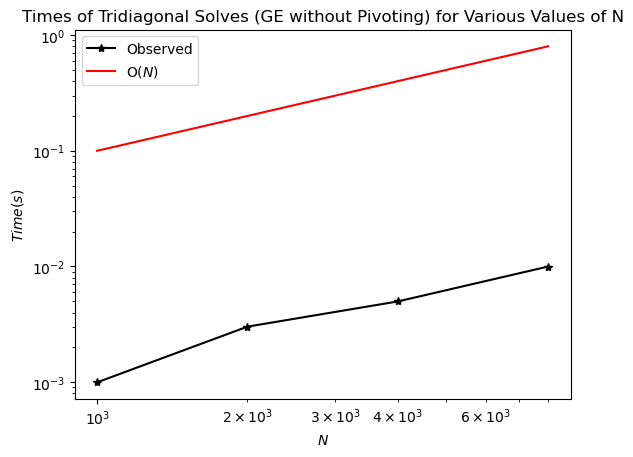

In [26]:
print(f"time list: {time_list}")

plt.loglog(N_arr,time_list, 'k-*', label='Observed')
plt.loglog(N_arr, np.array(N_arr) * 1e-4, 'r-', label='O$(N)$')

plt.xlabel('$N$')
plt.ylabel('$Time (s)$')
plt.title("Times of Tridiagonal Solves (GE without Pivoting) for Various Values of N")

plt.legend(loc='upper left')

plt.show()
